# 4. Analyzing Differences in Habitat Metrics
MS 263 Final Project

Caroline Daley | Moss Landing Marine Laboratories 

May 2025

In [28]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg 
from scipy.stats import ttest_ind
from scipy import linalg
import os
import seaborn as sns

Import the Python function file 'Habitat_Metric_Plotting.py' to plot each habitat metrics by MPA and REF sites within a desired location. This Python file is housed locally in this respository. 

In [4]:
import habitat_metric_plotting

Import the habitat metrics dataset that you generated in the 'Zonal Statistics with CCFRP Gridcells' notebook as a .csv file. Remove columns and rows of habitat metrics that are populated by NaN values. 

In [20]:
df = pd.read_csv('habitat_metrics_summary.csv')

# Remove rows where habitat metrics are Nan
habitat_metrics = ['slope', 'aspect', 'curvature', 'index', 'rugosity']
df_cleaned = df.dropna(subset=habitat_metrics, how='all')

# Remove columns that have no data 
df_cleaned = df_cleaned.dropna(axis=1, how='all')

In [ ]:
df_cleaned

Define the habiat metrics that you are intersted in analyzing. This variable will be called throughout the code, so make sure it's up to date! 

In [21]:
habitat_metrics = ['slope', 'aspect', 'curvature', 'index', 'rugosity']

Plot each habitat metric as a histogram to examine the distribution of the data. 

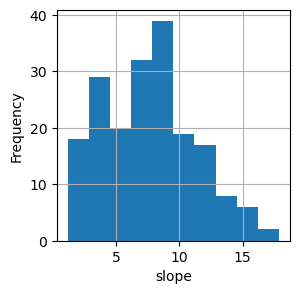

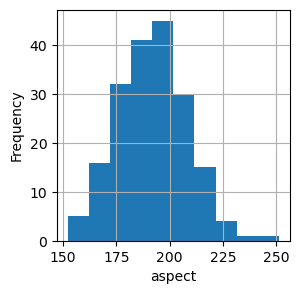

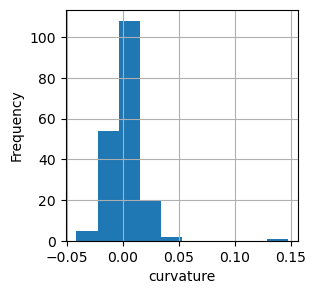

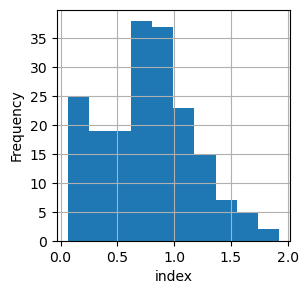

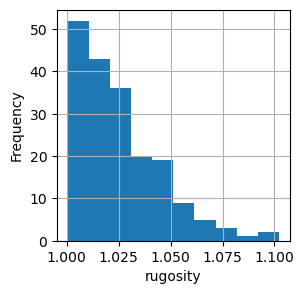

In [22]:
# loop through to plot histogram to examine data 
for metric in habitat_metrics: 
    plt.figure(figsize = (3, 3))
    df_cleaned[metric].hist()
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

Examine variance between habitat metrics by 'Site' and 'ID' (MPA/REF). 

In [23]:
for metric in habitat_metrics:
    print(f"Variance for {metric}:")
    
    # Group by 'Site' and 'ID' (Location), then calculate variance
    group_variance = df_cleaned.groupby(['Location', 'Site'])[metric].var(ddof=1) # how many degrees of freedom? 
    print(group_variance)

#... which these are not 

Variance for slope:
Location          Site
Ano Nuevo         MPA      5.317991
                  REF      2.895216
Bodega Head       MPA      1.767264
                  REF      3.027698
Cape Mendocino    MPA     10.369062
                  REF     12.323760
Point Buchon      MPA      4.737629
                  REF      3.540699
Point Conception  MPA      0.463746
                  REF      0.780083
Stewarts Point    MPA      5.251366
                  REF      5.731914
Name: slope, dtype: float64
Variance for aspect:
Location          Site
Ano Nuevo         MPA      50.430306
                  REF     113.827592
Bodega Head       MPA      67.006351
                  REF     310.847397
Cape Mendocino    MPA     187.982378
                  REF     169.494384
Point Buchon      MPA      93.728205
                  REF     228.877623
Point Conception  MPA     255.732785
                  REF     465.662698
Stewarts Point    MPA     149.106650
                  REF     327.386532
Name: asp

## MPA vs REF Within Locations

Here, I am opting for a Welch's t-test to explore differences in habitat metrics between MPA and REF sites within the same location. I opted use this test even though the data are not normal because of the trade off's in power of non-parametric tests. 

Here, I examine each how each habitat compares between MPA and REF sites at each CCFRP locations. 

### Plot Habitat Metric by Location 


First, let's plot the data! In the ['habitat_metric_plotting.py'](http://localhost:8888/lab/tree/Project/ms263-main%202/habitat_metric_plotting.py) Python function file, there is a function that will plot each habitat metric between MPA and REF areas in a given CCFRP sampling location. 

Plot and explore habitat metrics at Cape Mendocino!

Figure saved to: Figures/habitat_metrics_Point Buchon_plot.png


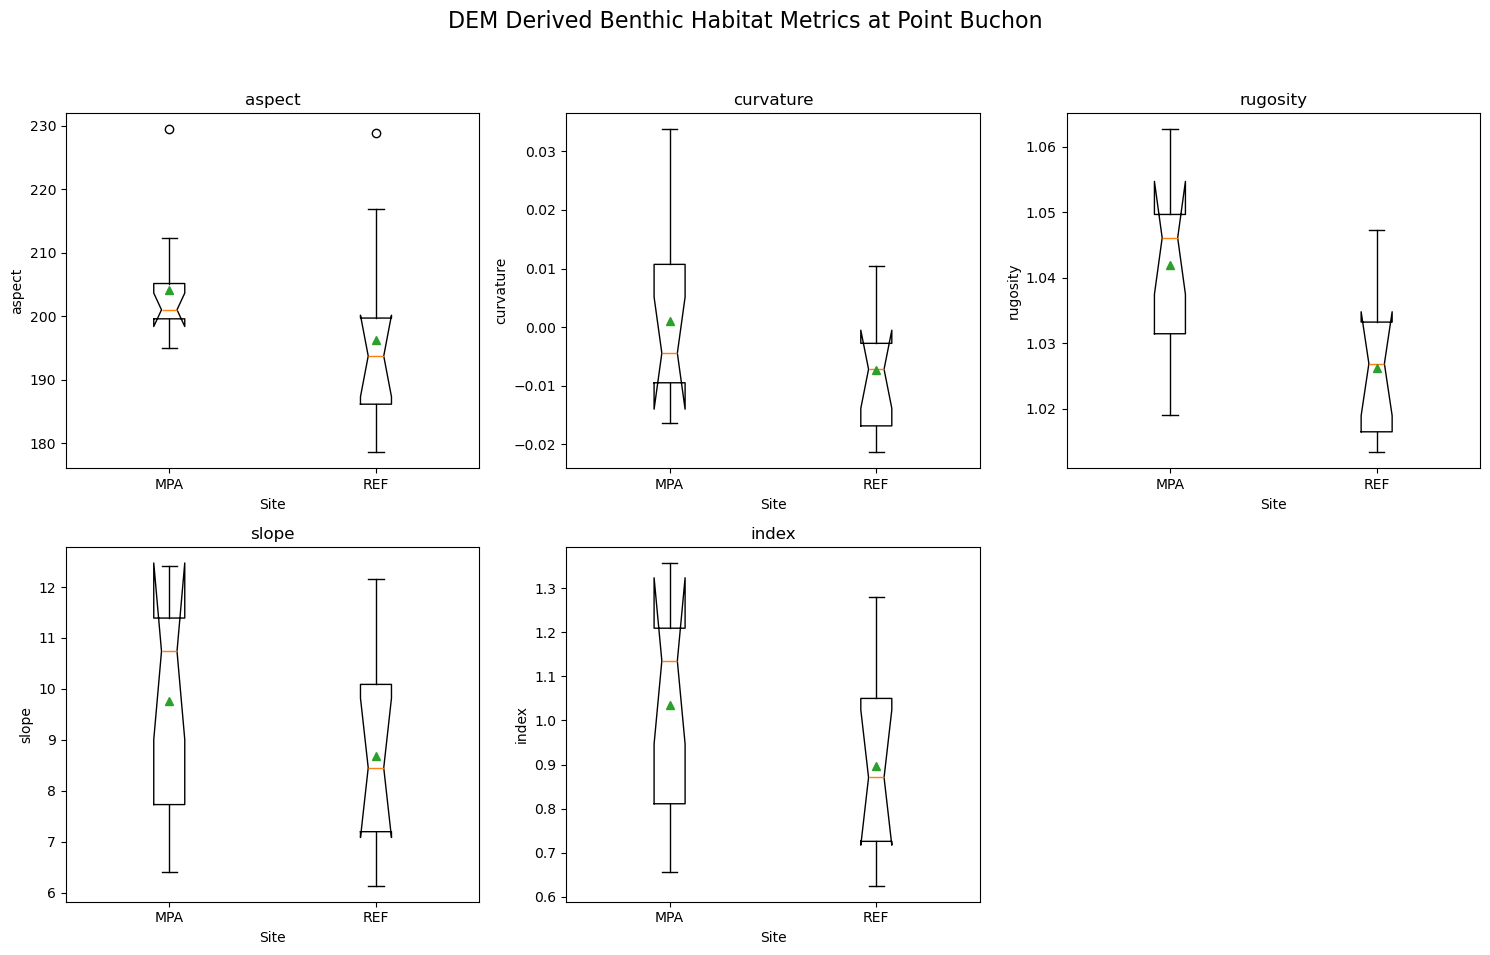

In [58]:
from habitat_metric_plotting import plot_site_metrics
plot_site_metrics(df_cleaned, 'Point Buchon', 'Figures')

#### Examine Differences Between MPA and REF sites 

This code defines a function that delivers the results of a Welch's t-test on each habitat metric between the MPA and REF sites in that location. I opted to use a Welch's t-test because my data are non-parametric, but I don't want to compromise the power of my statistics. 

In [ ]:
def site_ttest(location): 
    location_data = df_cleaned[df_cleaned['Location'] == location]
    
    print(f"Site: {location}")
    
    for metric in habitat_metrics: 
        print(f"Metric: {metric}")
        
        mpa = location_data[location_data['Site'] == 'MPA'][metric].dropna()
        ref = location_data[location_data['Site'] == 'REF'][metric].dropna()
        
        stat, p = ttest_ind(mpa, ref, equal_var=False)           
        
        print(f" t = {stat:.3f}, p = {p:.4f}")

Let's take a look at which habitat metrics differ significantly between the gridcells in the MPA and reference areas at Point Buchon. 

In [ ]:
site_ttest('Point Buchon')

## MPA vs REF Across Locations

Now, let's explore at how habitat metrics vary by both geographic location and MPA/REF designation. More clearly: Do habitat metrics differ between geographic locations, between MPA/REF designations agnostic of geographic locations, and between MPA/REF designations by geographic location. 

My data are non-parametric, but I am opting to use 2-way ANOVA because it provides information on the interaction of my independent location variables on habitat metrics. 

In [ ]:
for metric in habitat_metrics: 
    print(f"\nMetric: {metric}")
    
    aov = pg.anova(data=df_cleaned, dv=metric, between=['Location', 'Site'], detailed=True)
    print(aov[['Source', 'F', 'p-unc', 'np2']])

This is a lot of information to take in. Let's isolate one habitat metric to visualize how it changes between MPA/REF sites across geographic locations. 

In [ ]:
def plot_metric_by_ID_site(df, metric):
    plt.figure(figsize=(10, 6))

    sns.boxplot(data=df, x='Location', y=metric, hue='Site', showmeans=True, notch=True)

    plt.title(f"{metric} by Site and ID (MPA vs REF)")
    plt.ylabel(metric)
    plt.xlabel("Location")
    plt.legend(title="Site")
    plt.tight_layout()

    output_path = os.path.join("Figures", f"{metric}_by_location+site_plot.png")
    plt.savefig(output_path, dpi=300)
    
    plt.show()

In [ ]:
plot_metric_by_ID_site(df_cleaned, 'rugosity')

Inspect statistical significance in the difference in mean rugosity between MPA and reference sites across locations. This 2-way ANOVA will report the statistical significance of the difference in rugosity between locations (as 'Location'), sites (MPA versus REF as 'Site'), and the interaction of locations and sites (as 'Location * Site'). 

In [24]:
def ID_site_ANOVA(df, metric): 
    
    # Perform the ANOVA
    aov = pg.anova(data=df, dv=metric, between=['Location', 'Site'], detailed=True)
    print(f"\n{metric} ANOVA: \n{aov}")

In [25]:
ID_site_ANOVA(df_cleaned, 'rugosity')


rugosity ANOVA: 
            Source        SS     DF        MS          F         p-unc  \
0         Location  0.024948    5.0  0.004990  20.327416  5.049818e-16   
1             Site  0.000948    1.0  0.000948   3.863566  5.090091e-02   
2  Location * Site  0.006253    5.0  0.001251   5.095040  2.164286e-04   
3         Residual  0.043692  178.0  0.000245        NaN           NaN   

        np2  
0  0.363461  
1  0.021244  
2  0.125201  
3       NaN  


If you're interested in seeing which locations, sites, or sites by location differ from one another, you can use the below function to perform a Tukey honestly significant difference (HSD) post hoc test. I am using a Tukey HSD post hoc on my variables with significant p values from the ANOVA. I am using the parametric Tukey HSD post hoc even though my data are not parametric based on the same concession above.

In [56]:
def TukeyHSD_ID_site(df, metric): 
    aov = pg.anova(data=df, dv=metric, between=['Location', 'Site'], detailed=True)
    # Check for significance by Location
    if aov.loc[aov['Source'] == 'Location', 'p-unc'].values[0] < 0.05: 
        location_posthoc = pg.pairwise_tukey(data=df, dv=metric, between='Location')
        print(f'\nTukey HSD Post Hoc for {metric} by Location:\n')
        print(location_posthoc[['A', 'B', 'diff', 'p-tukey']])
    else: 
        print(f"No significant difference for {metric} by Location.")
    
    # Check for significance by Site
    if aov.loc[aov['Source'] == 'Site', 'p-unc'].values[0] < 0.05:
        site_posthoc = pg.pairwise_tukey(data=df, dv=metric, between='Site')
        print(f'\nTukey HSD Post Hoc for {metric} by Site:\n')
        print(site_posthoc[['A', 'B', 'diff', 'p-tukey']])
    else: 
        print(f"No significant difference for {metric} by Site.")
    
    # Check for significance by Location * Site interaction
    if aov.loc[aov['Source'] == 'Location * Site', 'p-unc'].values[0] < 0.05:
        # Create interaction variable for Location * Site
        df['Location_Site'] = df['Location'].astype(str) + "_" + df['Site'].astype(str)
        
        # Run Tukey HSD for the interaction term
        interaction_posthoc = pg.pairwise_tukey(data=df, dv=metric, between='Location_Site')
        print(f'\nTukey HSD Post Hoc for {metric} by Location * Site:\n')
        
        sig_results = interaction_posthoc[interaction_posthoc['p-tukey'] < 0.05]

        if not sig_results.empty:
            print(sig_results[['A', 'B', 'diff', 'p-tukey']])
        else:
            print(f"No significant post hoc comparisons for {metric} in Location * Site interaction.")


    else: 
        print(f"No significant difference for {metric} by Location * Site interaction.")


In [57]:
TukeyHSD_ID_site(df_cleaned, 'rugosity')


Tukey HSD Post Hoc for rugosity by Location:

                   A                 B      diff       p-tukey
0          Ano Nuevo       Bodega Head  0.013163  6.950585e-02
1          Ano Nuevo    Cape Mendocino -0.003553  9.503242e-01
2          Ano Nuevo      Point Buchon -0.008140  5.842423e-01
3          Ano Nuevo  Point Conception  0.023956  2.708985e-05
4          Ano Nuevo    Stewarts Point -0.017474  1.427556e-02
5        Bodega Head    Cape Mendocino -0.016716  1.833037e-04
6        Bodega Head      Point Buchon -0.021303  2.045986e-04
7        Bodega Head  Point Conception  0.010793  1.842726e-01
8        Bodega Head    Stewarts Point -0.030637  1.159694e-07
9     Cape Mendocino      Point Buchon -0.004587  8.643325e-01
10    Cape Mendocino  Point Conception  0.027509  2.583065e-10
11    Cape Mendocino    Stewarts Point -0.013921  2.025392e-02
12      Point Buchon  Point Conception  0.032096  6.305186e-09
13      Point Buchon    Stewarts Point -0.009334  4.904112e-01
14  Poin